# 0. Standard imports

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sys.path.append('/Users/khalilouardini/Desktop/projects/scVI/scvi')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***import ete3 Tree***

In [3]:
from ete3 import Tree

tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/3726_NT_T1_tree.processed.collapsed.tree"
#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/tree_test.txt"
tree = Tree(tree_name, 1)

#tree = Tree()
#tree.populate(60)

for i, n in enumerate(tree.traverse('levelorder')):
    n.add_features(index=i)

***Prune tree***

In [4]:
for i, n in enumerate(tree.traverse()):
    print(i, n.name)

split_node = tree.search_nodes(name='2|2|2|2|2|0|2|2|2|0|2|2|0|2|0|2|2|2|0|2|2|2|2|0|0|0|0|0|0')[0]
sub_leaves = [n.name for n in split_node.get_leaves()]
tree.prune(sub_leaves)

0 0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0
1 0|0|0|0|0|0|0|0|0|2|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0
2 2|2|2|2|6|11|0|9|2|0|2|0|7|4|0|0|0|0|6|4|0|4|0|3|10|0|2|2|2
3 6|3|0|4|9|0|8|5|0|0|4|10|11|0|0|0|0|0|2|9|0|0|0|0|17|0|0|0|0
4 0|2|2|2|2|0|2|0|2|2|2|0|2|0|0|0|0|0|0|0|0|2|0|3|5|22|-|-|-
5 0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|2|0|0|0|0|0|0|0|0|0|0|0|0
6 0|0|0|0|0|0|0|0|0|2|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|2|2|2
7 2|6|4|5|0|0|3|15|8|2|6|0|0|0|0|0|6|24|13|12|0|3|8|10|0|26|4|6|0
8 L6.GTTTCTAGTGAAGGCT-1
9 L6.CCCTCCTCAGCTGCTG-1
10 L6.TGGCGCATCTCGTATT-1
11 6|3|0|4|9|0|8|5|12|0|4|10|11|17|35|0|0|0|2|9|4|0|0|8|17|0|0|0|0
12 L6.CGTGAGCTCACTCCTG-1
13 2|2|2|2|2|0|2|0|2|2|2|0|2|14|0|10|4|18|0|0|0|2|2|3|5|22|-|-|-
14 0|0|0|0|0|0|0|0|0|2|0|0|0|0|0|0|2|0|0|0|0|0|0|0|0|0|2|2|2
15 0|0|0|3|8|0|0|11|0|0|0|0|2|0|0|4|2|11|2|0|0|0|0|0|14|12|0|0|0
16 0|2|2|0|0|0|0|0|0|0|0|0|0|4|0|0|2|0|0|0|0|0|0|0|0|0|0|0|0
17 0|2|2|2|6|11|0|0|2|0|2|0|0|0|0|4|2|0|0|4|0|4|0|0|0|0|2|0|2
18 0|0|0|2|2|0|0|0|2|0|0|0|0|

In [150]:
# Data
from anndata import AnnData
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from dataset.tree import TreeDataset, GeneExpressionDataset
from dataset.poisson_glm import Poisson_GLM
from dataset.anndataset import AnnDatasetFromAnnData

# Models
from models import *;
import scanpy as sc
from inference.tree_inference import TreeTrainer
from inference.inference import UnsupervisedTrainer
from inference import posterior
from models.treevae import TreeVAE

# Utils
from utils.data_util import get_leaves, get_internal
from utils.metrics import ks_pvalue, accuracy_imputation, correlations, knn_purity, knn_purity_stratified
from utils.plots_util import plot_histograms, plot_scatter_mean, plot_ecdf_ks, plot_density
from utils.plots_util import plot_losses, plot_elbo, plot_common_ancestor, plot_one_gene, training_dashboard
from utils.baselines import avg_weighted_baseline, scvi_baseline, scvi_baseline_z, cascvi_baseline_z

# 1. Simulations (Poisson GLM)

In [8]:
d = 10
g = 1000
vis = False
leaves_only = False
var = 1.0

#glm = Poisson_GLM(tree_name, g, d, vis, leaves_only, var)
glm = Poisson_GLM(tree, g, d, vis, leaves_only, var)

glm.simulate_latent()

Generate gene expression count data

In [9]:
glm.simulate_ge()
# Quality Control (i.e Gene Filtering)
#glm.gene_qc()
glm.X.shape

(474, 1000)

GLM parameters

In [10]:
glm.W.shape, glm.beta.shape

((10, 1000), (1000,))

***Binomial thinning***

In [11]:
print("Proportion of dropouts: {}".format(np.mean(glm.X == 0)))
#glm.binomial_thinning(p=0.01)
#print("Proportion of dropouts after Binomial thinning: {}".format(np.mean(glm.X == 0)))

Proportion of dropouts: 0.44079113924050634


Get the data and the indexes at the leaves

In [12]:
# Latent vectors
leaves_z, _, _ = get_leaves(glm.z, glm.mu, tree)

#FIXED training set
leaves_X, leaves_idx, mu = get_leaves(glm.X, glm.mu, tree)

# internal nodes data (for imputation)
internal_X, internal_idx, internal_mu = get_internal(glm.X, glm.mu, tree)

leaves_X.shape, mu.shape, internal_X.shape, internal_mu.shape, leaves_z.shape

((402, 1000), (402, 1000), (72, 1000), (72, 1000), (402, 10))

***Visualizing the data***

***Tree***

In [13]:
plot_one_gene(tree=tree,
             X=glm.X,
             g=0,
             node_sizes=[800 for i in range(glm.X.shape[0])],
             var='latent',
             size=1000,
             show_index=True,
             save_fig=True,
             figsize=(180, 100)
             )

***Simulated latent space***

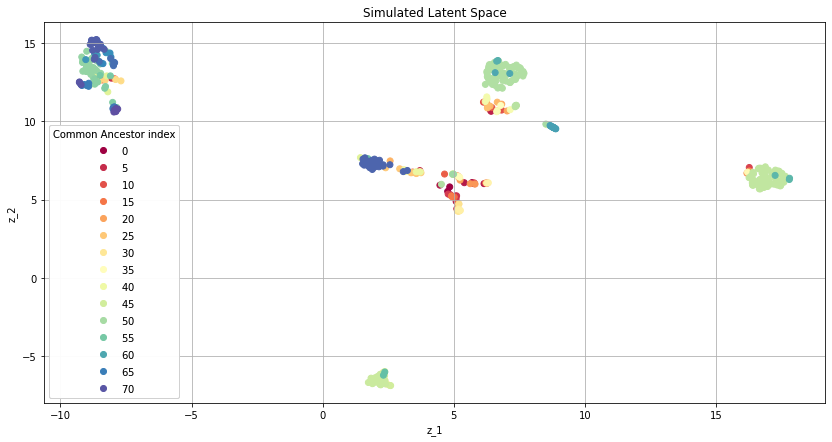

In [16]:
plot_common_ancestor(tree,
                     glm.z,
                     embedding='umap',
                     give_labels=False)

# 2. Fitting CascVI

In [49]:
import scanpy as sc

# anndata + gene and celle filtering
adata = AnnData(leaves_X)
adata.obs_names = [n.name for n in list(tree.get_leaves())]
#sc.pp.filter_genes(adata, min_counts=3)
#sc.pp.filter_cells(adata, min_counts=0)

In [50]:
scvi_dataset = AnnDatasetFromAnnData(adata)
scvi_dataset.initialize_cell_attribute('barcodes', adata.obs_names)

[2021-04-05 15:12:06,329] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-05 15:12:06,330] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-05 15:12:06,338] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-05 15:12:06,340] INFO - scvi.dataset.dataset | Downsampled from 402 to 402 cells


***Create a TreeDataset object***

In [135]:
# treeVAE
import copy

tree_bis = copy.deepcopy(tree)
cas_dataset = TreeDataset(scvi_dataset, tree=tree_bis)
cas_dataset

# No batches beacause of the message passing
use_batches = False
use_cuda = False

[2021-04-05 16:32:17,429] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2021-04-05 16:32:17,430] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2021-04-05 16:32:17,431] INFO - scvi.dataset.dataset | Keeping 1000 genes
[2021-04-05 16:32:17,443] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-05 16:32:17,446] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-05 16:32:17,448] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-05 16:32:17,451] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-05 16:32:17,453] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-05 16:32:17,464] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-05 16:32:17,465] INFO - scvi.dataset.dataset | Downsampled from 402 to 402 cells


***Initialize model***

In [136]:
#var = 1.0
vae = TreeVAE(cas_dataset.nb_genes,
              tree = cas_dataset.tree,
              n_batch=cas_dataset.n_batches * use_batches,
              n_latent=glm.latent,
              n_hidden=128,
              n_layers=1,
              reconstruction_loss='poisson',
              prior_t = var,
              ldvae = True
             )

==== We will use a linear decoder ===


In [137]:
import torch

new_weight = torch.from_numpy(glm.W.T).float()
new_bias = torch.from_numpy(glm.beta).float()

with torch.no_grad():
    vae.decoder.factor_regressor.fc_layers[0][0].weight = torch.nn.Parameter(new_weight)
    vae.decoder.factor_regressor.fc_layers[0][0].bias = torch.nn.Parameter(new_bias)
    
for param in vae.decoder.factor_regressor.fc_layers[0][0].parameters():
    param.requires_grad = False
    
vae.decoder

LinearDecoderSCVI(
  (factor_regressor): FCLayers(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Linear(in_features=10, out_features=1000, bias=True)
        (1): None
        (2): None
        (3): None
      )
    )
  )
  (px_dropout_decoder): FCLayers(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Linear(in_features=10, out_features=1000, bias=True)
        (1): None
        (2): None
        (3): None
      )
    )
  )
)

In [139]:
assert(vae.decoder.factor_regressor.fc_layers[0][0].weight.numpy().all() == glm.W.T.all())
assert(vae.decoder.factor_regressor.fc_layers[0][0].bias.numpy().all() == glm.beta.all())

***Are we able to generate the gene expression data by decoding the simulated latent space?***

In [68]:
px_scale, px_r, px_rate, px_dropout = vae.decoder.forward(vae.dispersion,
                                                        torch.from_numpy(leaves_z).float(),
                                                          torch.from_numpy(np.array([np.log(10000)])).float(),
                                                          0)

In [69]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(mu, px_scale)
print("the distance between the Poisson and the NB means is {}".format(rmse))

the distance between the Poisson and the NB means is 4.9991533839583956e-08


***Hyperparameters***

In [140]:
n_epochs = 400
lr = 1e-3
lambda_ = 1.0

***trainer***

In [141]:
freq = 100
trainer = TreeTrainer(
    model = vae,
    gene_dataset = cas_dataset,
    lambda_ = lambda_,
    train_size=1.0,
    test_size=0,
    use_cuda=use_cuda,
    frequency=freq,
    n_epochs_kl_warmup=None
)

train_leaves:  [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], [114], [115], [116], [117], [118], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152], [153], [154], [155], [1

***Start training***

In [142]:
trainer.train(n_epochs=n_epochs,
              lr=lr)

computing elbo
training:   0%|          | 0/400 [00:00<?, ?it/s]ELBO Loss: 1488184844.5952222
KL divergence: 1.5444717027654695
ELBO Loss: 1324348477.484727
KL divergence: 1.4081777695992692
ELBO Loss: 971702651.5867958
KL divergence: 1.2718334292891014
training:   1%|          | 3/400 [00:00<00:15, 25.85it/s]ELBO Loss: 873112900.8898588
KL divergence: 1.1772575568203902
ELBO Loss: 695159388.9241482
KL divergence: 1.1107884497191776
ELBO Loss: 746602951.2633746
KL divergence: 1.0852984528043377
training:   2%|▏         | 6/400 [00:00<00:14, 26.71it/s]ELBO Loss: 666787202.052957
KL divergence: 1.0922301942436257
ELBO Loss: 620010307.0252024
KL divergence: 1.116626265037119
ELBO Loss: 597697013.3274099
KL divergence: 1.1678024216077814
training:   2%|▏         | 9/400 [00:00<00:14, 26.67it/s]ELBO Loss: 594420753.7821224
KL divergence: 1.2312313098812577
ELBO Loss: 580021827.2067287
KL divergence: 1.3125314285506064
ELBO Loss: 523132186.1775788
KL divergence: 1.3801453244033737
training: 

ELBO Loss: 300373657.5173132
KL divergence: 6.491048177083333
ELBO Loss: 297223995.2126191
KL divergence: 6.56105762690454
training:  26%|██▌       | 102/400 [00:03<00:12, 24.83it/s]ELBO Loss: 295828331.8588228
KL divergence: 6.5352096937189055
ELBO Loss: 293673505.3827629
KL divergence: 6.606537017063122
ELBO Loss: 294225138.3233994
KL divergence: 6.679105084926928
training:  26%|██▋       | 105/400 [00:04<00:11, 25.48it/s]ELBO Loss: 292799210.1586043
KL divergence: 6.734044013331778
ELBO Loss: 293925009.0876108
KL divergence: 6.723392315764926
ELBO Loss: 292684639.25689846
KL divergence: 6.785864986590485
training:  27%|██▋       | 108/400 [00:04<00:11, 25.87it/s]ELBO Loss: 293090932.9911297
KL divergence: 6.796484496462997
ELBO Loss: 294578159.0493005
KL divergence: 6.840019871346393
ELBO Loss: 291557530.17560506
KL divergence: 6.90239112056903
training:  28%|██▊       | 111/400 [00:04<00:11, 25.90it/s]ELBO Loss: 291466705.1510512
KL divergence: 6.924521071400808
ELBO Loss: 29133725

training:  50%|█████     | 201/400 [00:07<00:09, 21.06it/s]ELBO Loss: 273730395.71926457
KL divergence: 9.821160311722636
ELBO Loss: 273360237.6078023
KL divergence: 9.882726868586754
ELBO Loss: 273142873.8086993
KL divergence: 9.892539864155784
training:  51%|█████     | 204/400 [00:08<00:09, 21.34it/s]ELBO Loss: 273278268.36638105
KL divergence: 9.968266577269901
ELBO Loss: 273033318.034191
KL divergence: 9.996418056203359
ELBO Loss: 273502833.0226613
KL divergence: 9.952647043104788
training:  52%|█████▏    | 207/400 [00:08<00:08, 21.60it/s]ELBO Loss: 271428628.9243416
KL divergence: 10.027629188044154
ELBO Loss: 272225160.1610137
KL divergence: 10.071576322489117
ELBO Loss: 272895250.40337664
KL divergence: 10.095458984375
training:  52%|█████▎    | 210/400 [00:08<00:08, 21.81it/s]ELBO Loss: 272772950.22539544
KL divergence: 10.069225406172263
ELBO Loss: 272728821.80629057
KL divergence: 10.14287206545398
ELBO Loss: 272381577.92644936
KL divergence: 10.163579684584889
training:  53

training:  75%|███████▌  | 300/400 [00:12<00:04, 21.81it/s]ELBO Loss: 264722022.76216614
KL divergence: 12.327622143190299
ELBO Loss: 265065990.11246425
KL divergence: 12.332315473414178
ELBO Loss: 265794180.17219296
KL divergence: 12.330958731731965
training:  76%|███████▌  | 303/400 [00:12<00:04, 22.39it/s]ELBO Loss: 265147211.4479962
KL divergence: 12.459301393423507
ELBO Loss: 264566468.39776093
KL divergence: 12.509747405550373
ELBO Loss: 265090047.37705192
KL divergence: 12.514009542133085
training:  76%|███████▋  | 306/400 [00:12<00:04, 22.81it/s]ELBO Loss: 265050473.37090203
KL divergence: 12.486448373367537
ELBO Loss: 264472340.22283223
KL divergence: 12.539258055425995
ELBO Loss: 264718634.81786254
KL divergence: 12.601103369869403
training:  77%|███████▋  | 309/400 [00:12<00:03, 23.14it/s]ELBO Loss: 264241857.71207693
KL divergence: 12.548202590562811
ELBO Loss: 264733740.94155112
KL divergence: 12.567851659670398
ELBO Loss: 264425780.08536386
KL divergence: 12.5742017451803

training: 100%|█████████▉| 399/400 [00:16<00:00, 20.81it/s]ELBO Loss: 260752641.1688628
KL divergence: 14.420637292055348
computing elbo
training: 100%|██████████| 400/400 [00:16<00:00, 23.88it/s]


***Loss Functions***

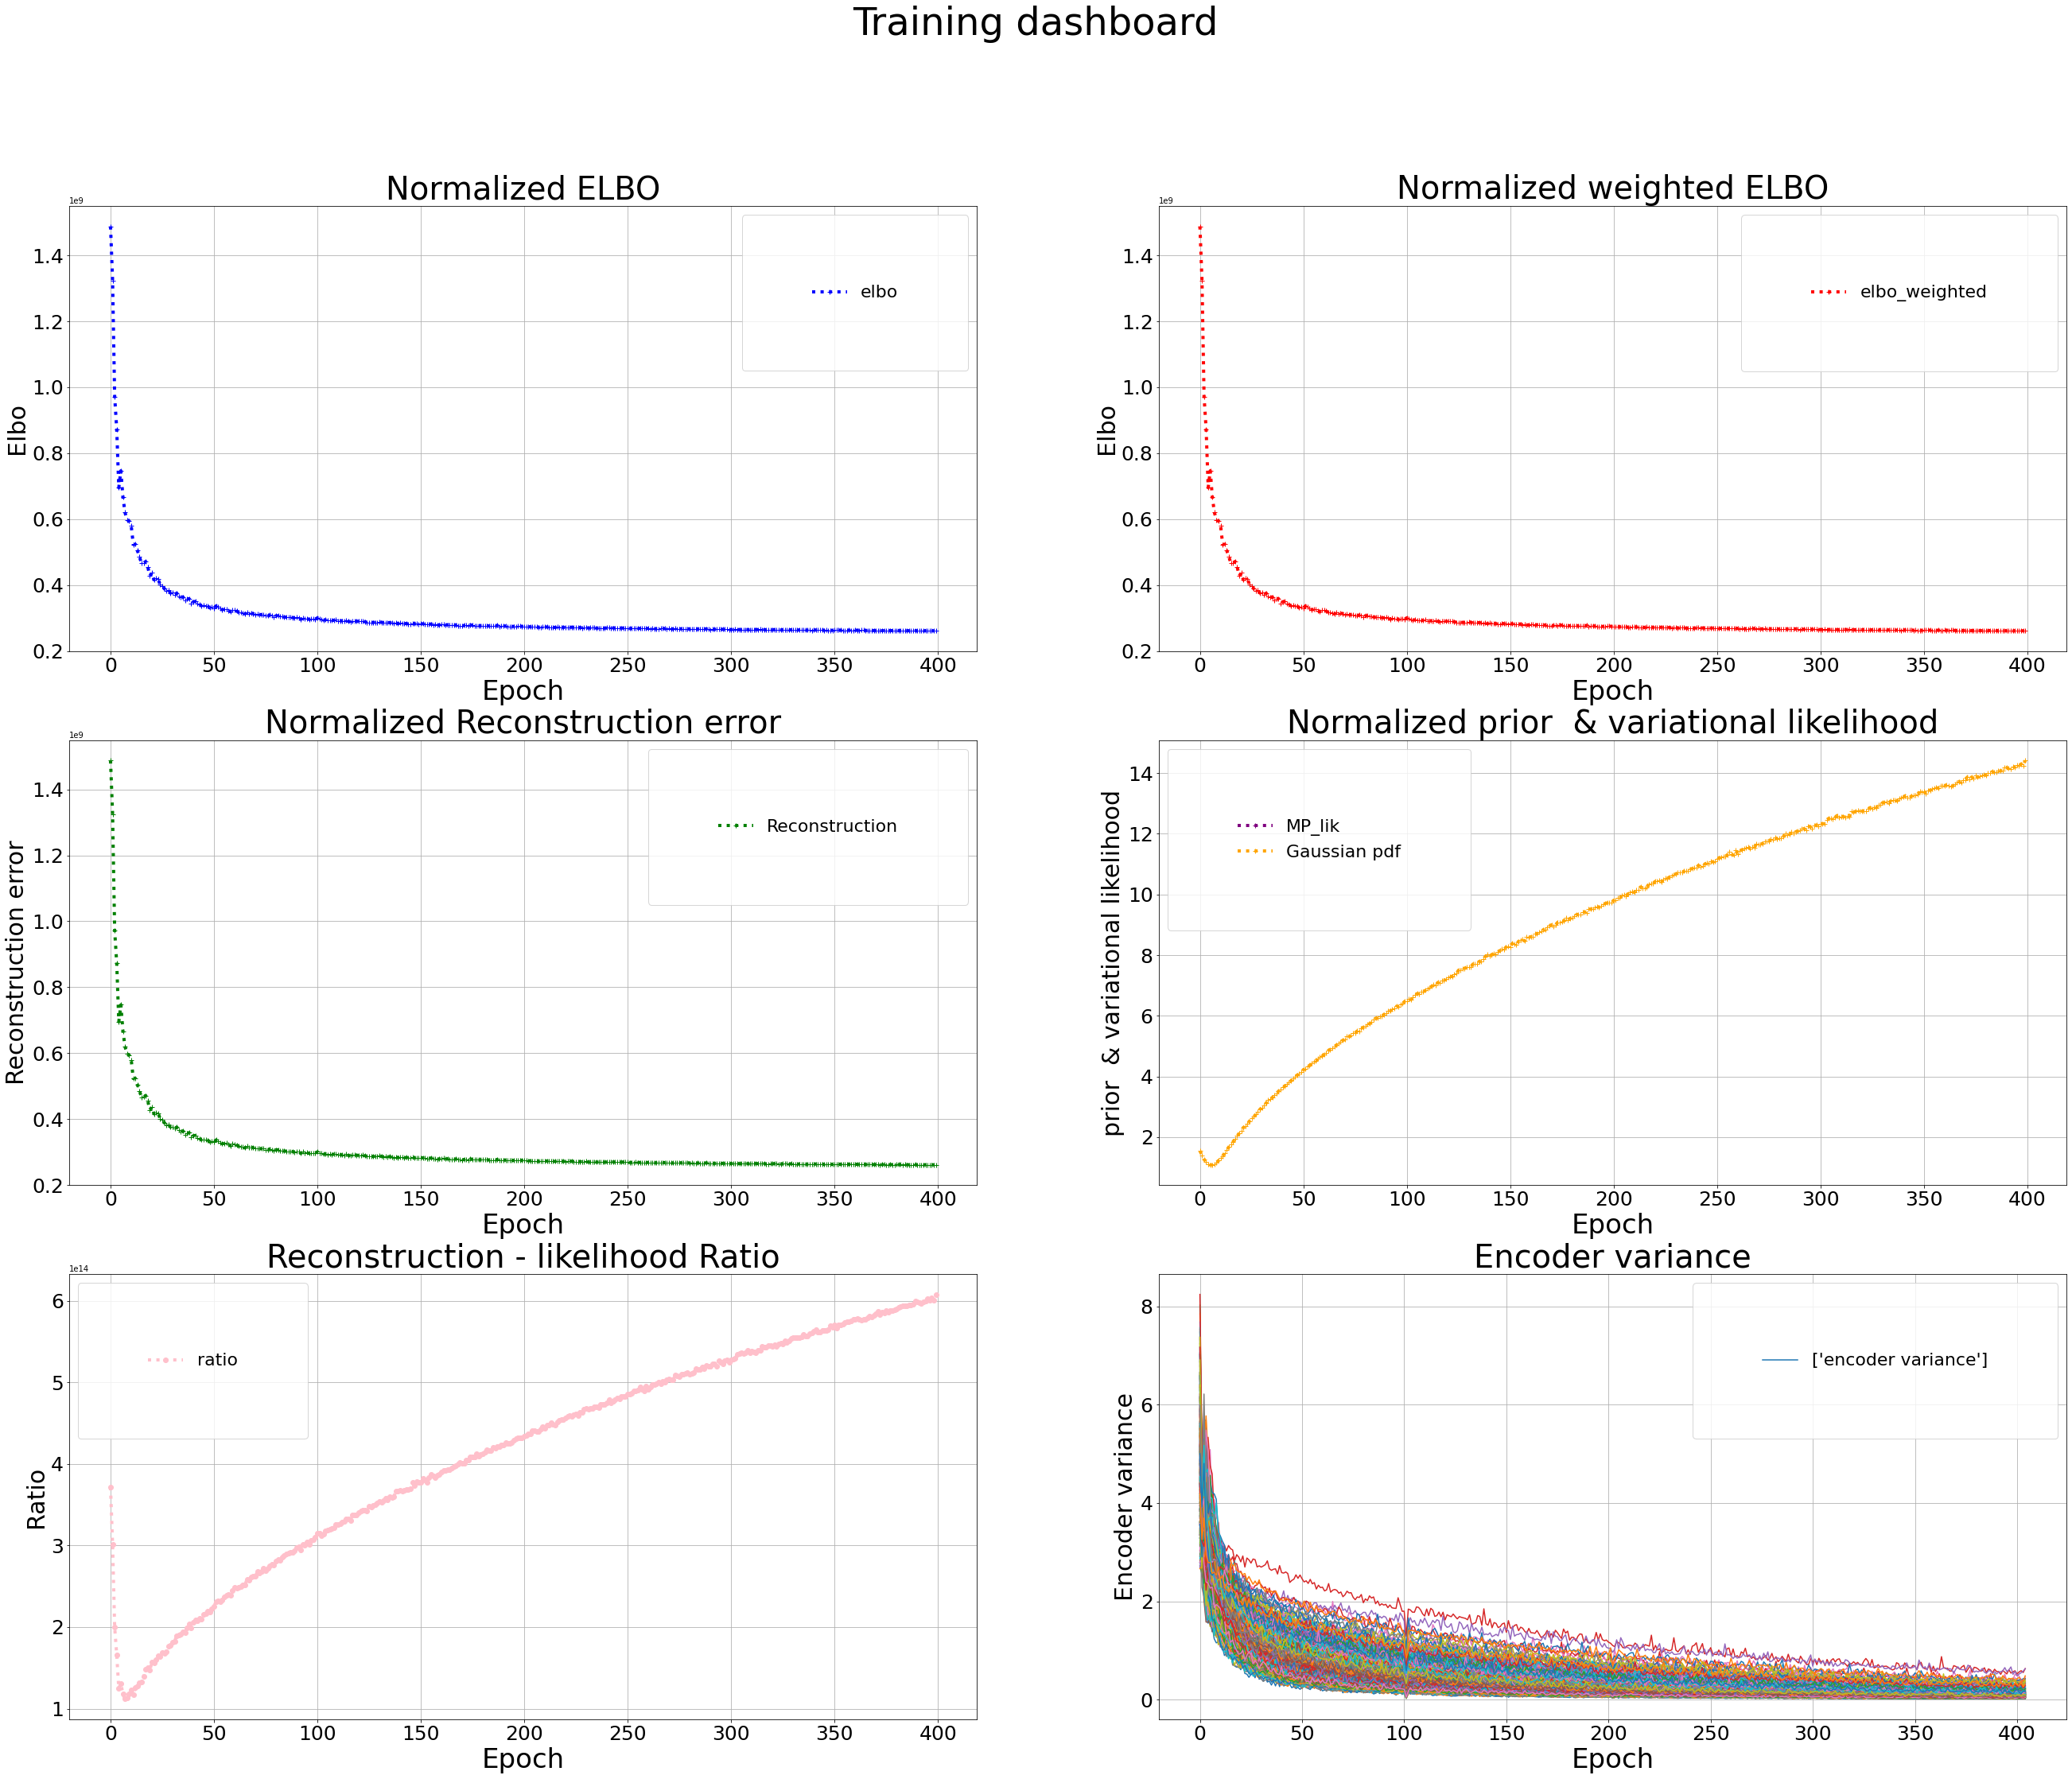

In [143]:
training_dashboard(trainer, vae.encoder_variance)

### 3. Posterior and MV imputation

In [76]:
full_posterior = trainer.create_posterior(trainer.model, cas_dataset, trainer.clades,
                                indices=np.arange(len(cas_dataset))
                                         )

***Missing Value imputation By Posterior Predictive sampling***

In [85]:
empirical_l = np.mean(np.sum(glm.X, axis=1))

# CascVI impitations
imputed = {}
imputed_z = {}
imputed_gt = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed[n.name], imputed_z[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l
                                                           )
        imputed_gt[n.name] = glm.X[n.index]

In [86]:
imputed_X = [x for x in imputed.values()]
imputed_X = np.array(imputed_X).reshape(-1, cas_dataset.X.shape[1])
#plot_histograms(imputed_X, "Histogram of CasscVI imputed gene expression data")

***CascVI Baseline 1 (Average of reconstructions)***

In [87]:
imputed_cascvi_1 = scvi_baseline(tree, full_posterior, True)

***CascVI Baseline 2 (Reconstruction of Averaged latent space)***

In [88]:
imputed_cascvi_2, imputed_cascvi_2_z = scvi_baseline_z(tree=tree,
                                   model=vae,
                                   posterior=full_posterior,
                                   weighted=True,
                                   n_samples_z=1,
                                   library_size=empirical_l
                                  )

# 4. Baselines

***Baseline 1: Unweighted Average of gene expression in Clade***

The simple idea here is to impute the value of an internal node, with the (un)weighted average of the gene expression values of the leaves, taking the query internal node as the root of the subtree.

In [89]:
weighted = True
imputed_avg = avg_weighted_baseline(tree, True, glm.X)

#get internal nodes
avg_X = np.array([x for x in imputed_avg.values()]).reshape(-1, glm.X.shape[1])
internal_avg_X, _, _ = get_internal(avg_X, glm.mu, tree)
#plot_histograms(avg_X,
#               'Histograms of imputed GE values with the average baseline')

***Baseline 2: (Un)weighted Average of decoded latent vectors, with scVI***

We use the same averaging of the subtrees leaves in **Baseline 1**, only this time, the gene expression data is recovered with scVI

In [151]:
# anndata
gene_dataset = GeneExpressionDataset()
gene_dataset.populate_from_data(leaves_X)

[2021-04-05 16:34:40,436] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-05 16:34:40,437] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


In [152]:
import torch

n_epochs = 400

vae_scvi = VAE(gene_dataset.nb_genes,
                  n_batch=cas_dataset.n_batches * use_batches,
                  n_hidden=128,
                  n_layers=1,
                  reconstruction_loss='poisson',
                  n_latent=glm.latent)


new_weight = torch.from_numpy(glm.W.T).float()
new_bias = torch.from_numpy(glm.beta).float()

with torch.no_grad():
    vae_scvi.decoder.factor_regressor.fc_layers[0][0].weight = torch.nn.Parameter(new_weight)
    vae_scvi.decoder.factor_regressor.fc_layers[0][0].bias = torch.nn.Parameter(new_bias)
    
for param in vae_scvi.decoder.factor_regressor.fc_layers[0][0].parameters():
    param.requires_grad = False
    

training:   0%|          | 0/400 [00:00<?, ?it/s]tensor(1.4083, grad_fn=<MulBackward0>)
tensor(7.0707e+08, grad_fn=<MulBackward0>)
tensor(2.4143, grad_fn=<MulBackward0>)
tensor(4.5183e+08, grad_fn=<MulBackward0>)
tensor(3.7770, grad_fn=<MulBackward0>)
tensor(4.3004e+08, grad_fn=<MulBackward0>)
tensor(4.8380, grad_fn=<MulBackward0>)
tensor(4.2021e+08, grad_fn=<MulBackward0>)
tensor(4.8170, grad_fn=<MulBackward0>)
tensor(3.7146e+08, grad_fn=<MulBackward0>)
tensor(5.0985, grad_fn=<MulBackward0>)
tensor(3.2129e+08, grad_fn=<MulBackward0>)
tensor(5.2714, grad_fn=<MulBackward0>)
tensor(3.6947e+08, grad_fn=<MulBackward0>)
tensor(5.4146, grad_fn=<MulBackward0>)
tensor(2.7686e+08, grad_fn=<MulBackward0>)
training:   0%|          | 2/400 [00:00<00:23, 16.62it/s]tensor(5.4768, grad_fn=<MulBackward0>)
tensor(3.0542e+08, grad_fn=<MulBackward0>)
tensor(5.6244, grad_fn=<MulBackward0>)
tensor(3.0058e+08, grad_fn=<MulBackward0>)
tensor(6.0966, grad_fn=<MulBackward0>)
tensor(2.8464e+08, grad_fn=<MulBack

tensor(25.1408, grad_fn=<MulBackward0>)
tensor(1.0014e+08, grad_fn=<MulBackward0>)
tensor(25.2049, grad_fn=<MulBackward0>)
tensor(55490396., grad_fn=<MulBackward0>)
tensor(24.9588, grad_fn=<MulBackward0>)
tensor(85998920., grad_fn=<MulBackward0>)
training:   6%|▌         | 24/400 [00:01<00:23, 15.94it/s]tensor(25.7134, grad_fn=<MulBackward0>)
tensor(79974384., grad_fn=<MulBackward0>)
tensor(25.8473, grad_fn=<MulBackward0>)
tensor(55130212., grad_fn=<MulBackward0>)
tensor(25.6981, grad_fn=<MulBackward0>)
tensor(60405796., grad_fn=<MulBackward0>)
tensor(25.3650, grad_fn=<MulBackward0>)
tensor(1.2119e+08, grad_fn=<MulBackward0>)
tensor(26.1202, grad_fn=<MulBackward0>)
tensor(48952788., grad_fn=<MulBackward0>)
tensor(27.1151, grad_fn=<MulBackward0>)
tensor(50392132., grad_fn=<MulBackward0>)
tensor(27.3212, grad_fn=<MulBackward0>)
tensor(75846624., grad_fn=<MulBackward0>)
tensor(27.9939, grad_fn=<MulBackward0>)
tensor(1.1029e+08, grad_fn=<MulBackward0>)
training:   6%|▋         | 26/400 [00

tensor(36.0600, grad_fn=<MulBackward0>)
tensor(37107700., grad_fn=<MulBackward0>)
tensor(35.0844, grad_fn=<MulBackward0>)
tensor(39616512., grad_fn=<MulBackward0>)
tensor(34.7964, grad_fn=<MulBackward0>)
tensor(35876104., grad_fn=<MulBackward0>)
tensor(34.7519, grad_fn=<MulBackward0>)
tensor(69251784., grad_fn=<MulBackward0>)
tensor(36.0054, grad_fn=<MulBackward0>)
tensor(43128672., grad_fn=<MulBackward0>)
tensor(35.4020, grad_fn=<MulBackward0>)
tensor(37083256., grad_fn=<MulBackward0>)
tensor(36.3972, grad_fn=<MulBackward0>)
tensor(26499250., grad_fn=<MulBackward0>)
training:  12%|█▏        | 48/400 [00:02<00:20, 17.16it/s]tensor(36.1562, grad_fn=<MulBackward0>)
tensor(39447344., grad_fn=<MulBackward0>)
tensor(35.7911, grad_fn=<MulBackward0>)
tensor(36322832., grad_fn=<MulBackward0>)
tensor(36.2186, grad_fn=<MulBackward0>)
tensor(39738740., grad_fn=<MulBackward0>)
tensor(32.4474, grad_fn=<MulBackward0>)
tensor(49296584., grad_fn=<MulBackward0>)
tensor(35.9759, grad_fn=<MulBackward0>)


tensor(39.9126, grad_fn=<MulBackward0>)
tensor(39092956., grad_fn=<MulBackward0>)
tensor(39.1844, grad_fn=<MulBackward0>)
tensor(2.3741e+08, grad_fn=<MulBackward0>)
training:  18%|█▊        | 70/400 [00:04<00:20, 16.46it/s]tensor(39.8593, grad_fn=<MulBackward0>)
tensor(33934444., grad_fn=<MulBackward0>)
tensor(40.3366, grad_fn=<MulBackward0>)
tensor(35585788., grad_fn=<MulBackward0>)
tensor(41.1761, grad_fn=<MulBackward0>)
tensor(45934136., grad_fn=<MulBackward0>)
tensor(40.2003, grad_fn=<MulBackward0>)
tensor(81251160., grad_fn=<MulBackward0>)
tensor(40.7470, grad_fn=<MulBackward0>)
tensor(37427300., grad_fn=<MulBackward0>)
tensor(40.8851, grad_fn=<MulBackward0>)
tensor(51995080., grad_fn=<MulBackward0>)
tensor(40.3310, grad_fn=<MulBackward0>)
tensor(39654960., grad_fn=<MulBackward0>)
tensor(40.8620, grad_fn=<MulBackward0>)
tensor(46167140., grad_fn=<MulBackward0>)
training:  18%|█▊        | 72/400 [00:04<00:19, 16.64it/s]tensor(41.4224, grad_fn=<MulBackward0>)
tensor(31581472., grad_

tensor(45.1695, grad_fn=<MulBackward0>)
tensor(38988924., grad_fn=<MulBackward0>)
tensor(45.2877, grad_fn=<MulBackward0>)
tensor(41083200., grad_fn=<MulBackward0>)
tensor(45.1797, grad_fn=<MulBackward0>)
tensor(29911880., grad_fn=<MulBackward0>)
tensor(45.5823, grad_fn=<MulBackward0>)
tensor(29705134., grad_fn=<MulBackward0>)
tensor(45.2834, grad_fn=<MulBackward0>)
tensor(25421102., grad_fn=<MulBackward0>)
tensor(47.2457, grad_fn=<MulBackward0>)
tensor(52231020., grad_fn=<MulBackward0>)
training:  24%|██▎       | 94/400 [00:05<00:18, 16.51it/s]tensor(45.9978, grad_fn=<MulBackward0>)
tensor(27274946., grad_fn=<MulBackward0>)
tensor(45.3257, grad_fn=<MulBackward0>)
tensor(29559060., grad_fn=<MulBackward0>)
tensor(44.9040, grad_fn=<MulBackward0>)
tensor(28106184., grad_fn=<MulBackward0>)
tensor(42.1721, grad_fn=<MulBackward0>)
tensor(55790628., grad_fn=<MulBackward0>)
tensor(45.2757, grad_fn=<MulBackward0>)
tensor(33760728., grad_fn=<MulBackward0>)
tensor(46.6847, grad_fn=<MulBackward0>)


tensor(46.7967, grad_fn=<MulBackward0>)
tensor(39662628., grad_fn=<MulBackward0>)
training:  29%|██▉       | 116/400 [00:07<00:17, 16.67it/s]tensor(48.1839, grad_fn=<MulBackward0>)
tensor(32808718., grad_fn=<MulBackward0>)
tensor(48.2423, grad_fn=<MulBackward0>)
tensor(28592872., grad_fn=<MulBackward0>)
tensor(48.2919, grad_fn=<MulBackward0>)
tensor(22016388., grad_fn=<MulBackward0>)
tensor(45.5336, grad_fn=<MulBackward0>)
tensor(1.8531e+08, grad_fn=<MulBackward0>)
tensor(49.4275, grad_fn=<MulBackward0>)
tensor(28733144., grad_fn=<MulBackward0>)
tensor(47.8899, grad_fn=<MulBackward0>)
tensor(35968808., grad_fn=<MulBackward0>)
tensor(46.7849, grad_fn=<MulBackward0>)
tensor(40263448., grad_fn=<MulBackward0>)
tensor(45.8941, grad_fn=<MulBackward0>)
tensor(1.2116e+08, grad_fn=<MulBackward0>)
training:  30%|██▉       | 118/400 [00:07<00:16, 16.91it/s]tensor(47.3560, grad_fn=<MulBackward0>)
tensor(48473672., grad_fn=<MulBackward0>)
tensor(46.8810, grad_fn=<MulBackward0>)
tensor(59239348., gr

tensor(99865888., grad_fn=<MulBackward0>)
tensor(48.4196, grad_fn=<MulBackward0>)
tensor(28763586., grad_fn=<MulBackward0>)
tensor(49.6506, grad_fn=<MulBackward0>)
tensor(35125668., grad_fn=<MulBackward0>)
tensor(50.1565, grad_fn=<MulBackward0>)
tensor(33503182., grad_fn=<MulBackward0>)
tensor(51.7828, grad_fn=<MulBackward0>)
tensor(27904604., grad_fn=<MulBackward0>)
training:  35%|███▌      | 140/400 [00:08<00:17, 15.13it/s]tensor(49.5232, grad_fn=<MulBackward0>)
tensor(38368016., grad_fn=<MulBackward0>)
tensor(50.1045, grad_fn=<MulBackward0>)
tensor(30850404., grad_fn=<MulBackward0>)
tensor(49.7047, grad_fn=<MulBackward0>)
tensor(29801200., grad_fn=<MulBackward0>)
tensor(51.7824, grad_fn=<MulBackward0>)
tensor(89568776., grad_fn=<MulBackward0>)
tensor(50.2452, grad_fn=<MulBackward0>)
tensor(31478174., grad_fn=<MulBackward0>)
tensor(50.7186, grad_fn=<MulBackward0>)
tensor(28054958., grad_fn=<MulBackward0>)
tensor(51.2108, grad_fn=<MulBackward0>)
tensor(31128038., grad_fn=<MulBackward0

training:  40%|████      | 162/400 [00:10<00:16, 14.80it/s]tensor(55.6071, grad_fn=<MulBackward0>)
tensor(37838456., grad_fn=<MulBackward0>)
tensor(54.9584, grad_fn=<MulBackward0>)
tensor(20722396., grad_fn=<MulBackward0>)
tensor(55.5445, grad_fn=<MulBackward0>)
tensor(19208708., grad_fn=<MulBackward0>)
tensor(54.6397, grad_fn=<MulBackward0>)
tensor(30008732., grad_fn=<MulBackward0>)
tensor(56.1393, grad_fn=<MulBackward0>)
tensor(20792422., grad_fn=<MulBackward0>)
tensor(54.7867, grad_fn=<MulBackward0>)
tensor(17588250., grad_fn=<MulBackward0>)
tensor(54.2058, grad_fn=<MulBackward0>)
tensor(20889242., grad_fn=<MulBackward0>)
tensor(56.9492, grad_fn=<MulBackward0>)
tensor(24882060., grad_fn=<MulBackward0>)
training:  41%|████      | 164/400 [00:10<00:15, 14.98it/s]tensor(55.4442, grad_fn=<MulBackward0>)
tensor(16970162., grad_fn=<MulBackward0>)
tensor(56.0403, grad_fn=<MulBackward0>)
tensor(17647458., grad_fn=<MulBackward0>)
tensor(55.3173, grad_fn=<MulBackward0>)
tensor(18448370., grad

tensor(61.9158, grad_fn=<MulBackward0>)
tensor(12069343., grad_fn=<MulBackward0>)
tensor(61.0266, grad_fn=<MulBackward0>)
tensor(12256432., grad_fn=<MulBackward0>)
tensor(62.0694, grad_fn=<MulBackward0>)
tensor(11510171., grad_fn=<MulBackward0>)
tensor(60.7179, grad_fn=<MulBackward0>)
tensor(14859522., grad_fn=<MulBackward0>)
training:  46%|████▋     | 186/400 [00:11<00:13, 15.33it/s]tensor(62.0313, grad_fn=<MulBackward0>)
tensor(11162548., grad_fn=<MulBackward0>)
tensor(62.0603, grad_fn=<MulBackward0>)
tensor(11694529., grad_fn=<MulBackward0>)
tensor(61.2032, grad_fn=<MulBackward0>)
tensor(11359502., grad_fn=<MulBackward0>)
tensor(63.0429, grad_fn=<MulBackward0>)
tensor(12266068., grad_fn=<MulBackward0>)
tensor(61.9553, grad_fn=<MulBackward0>)
tensor(12555244., grad_fn=<MulBackward0>)
tensor(62.2360, grad_fn=<MulBackward0>)
tensor(12648470., grad_fn=<MulBackward0>)
tensor(59.9626, grad_fn=<MulBackward0>)
tensor(15496849., grad_fn=<MulBackward0>)
tensor(58.2725, grad_fn=<MulBackward0>)

training:  52%|█████▏    | 208/400 [00:13<00:12, 15.13it/s]tensor(64.2322, grad_fn=<MulBackward0>)
tensor(11252874., grad_fn=<MulBackward0>)
tensor(63.0794, grad_fn=<MulBackward0>)
tensor(11115914., grad_fn=<MulBackward0>)
tensor(65.5214, grad_fn=<MulBackward0>)
tensor(11963891., grad_fn=<MulBackward0>)
tensor(63.6958, grad_fn=<MulBackward0>)
tensor(21297656., grad_fn=<MulBackward0>)
tensor(63.9326, grad_fn=<MulBackward0>)
tensor(10641304., grad_fn=<MulBackward0>)
tensor(63.8847, grad_fn=<MulBackward0>)
tensor(11419360., grad_fn=<MulBackward0>)
tensor(64.9799, grad_fn=<MulBackward0>)
tensor(11896337., grad_fn=<MulBackward0>)
tensor(65.1483, grad_fn=<MulBackward0>)
tensor(17626984., grad_fn=<MulBackward0>)
training:  52%|█████▎    | 210/400 [00:13<00:13, 14.44it/s]tensor(64.5522, grad_fn=<MulBackward0>)
tensor(12459753., grad_fn=<MulBackward0>)
tensor(63.7596, grad_fn=<MulBackward0>)
tensor(12830168., grad_fn=<MulBackward0>)
tensor(63.9542, grad_fn=<MulBackward0>)
tensor(10804191., grad

training:  58%|█████▊    | 232/400 [00:14<00:12, 13.95it/s]tensor(64.2069, grad_fn=<MulBackward0>)
tensor(10944148., grad_fn=<MulBackward0>)
tensor(65.9806, grad_fn=<MulBackward0>)
tensor(9762072., grad_fn=<MulBackward0>)
tensor(65.2103, grad_fn=<MulBackward0>)
tensor(11168792., grad_fn=<MulBackward0>)
tensor(62.9029, grad_fn=<MulBackward0>)
tensor(19832742., grad_fn=<MulBackward0>)
tensor(65.4875, grad_fn=<MulBackward0>)
tensor(9275904., grad_fn=<MulBackward0>)
tensor(63.9170, grad_fn=<MulBackward0>)
tensor(11124025., grad_fn=<MulBackward0>)
tensor(64.0116, grad_fn=<MulBackward0>)
tensor(10346733., grad_fn=<MulBackward0>)
tensor(66.7627, grad_fn=<MulBackward0>)
tensor(22171588., grad_fn=<MulBackward0>)
training:  58%|█████▊    | 234/400 [00:14<00:11, 14.20it/s]tensor(65.8377, grad_fn=<MulBackward0>)
tensor(12531383., grad_fn=<MulBackward0>)
tensor(64.9245, grad_fn=<MulBackward0>)
tensor(10166366., grad_fn=<MulBackward0>)
tensor(63.7817, grad_fn=<MulBackward0>)
tensor(11387309., grad_f

tensor(64.0173, grad_fn=<MulBackward0>)
tensor(9120596., grad_fn=<MulBackward0>)
tensor(64.1005, grad_fn=<MulBackward0>)
tensor(13359358., grad_fn=<MulBackward0>)
tensor(63.6862, grad_fn=<MulBackward0>)
tensor(12099783., grad_fn=<MulBackward0>)
tensor(63.4142, grad_fn=<MulBackward0>)
tensor(16278051., grad_fn=<MulBackward0>)
training:  64%|██████▍   | 256/400 [00:16<00:09, 15.54it/s]tensor(64.2234, grad_fn=<MulBackward0>)
tensor(10345783., grad_fn=<MulBackward0>)
tensor(64.2668, grad_fn=<MulBackward0>)
tensor(9957344., grad_fn=<MulBackward0>)
tensor(64.0892, grad_fn=<MulBackward0>)
tensor(10056629., grad_fn=<MulBackward0>)
tensor(66.0041, grad_fn=<MulBackward0>)
tensor(22282226., grad_fn=<MulBackward0>)
tensor(65.1897, grad_fn=<MulBackward0>)
tensor(9490933., grad_fn=<MulBackward0>)
tensor(65.1154, grad_fn=<MulBackward0>)
tensor(9567825., grad_fn=<MulBackward0>)
tensor(63.7937, grad_fn=<MulBackward0>)
tensor(10156094., grad_fn=<MulBackward0>)
tensor(64.5962, grad_fn=<MulBackward0>)
ten

training:  70%|██████▉   | 278/400 [00:17<00:07, 15.71it/s]tensor(64.9655, grad_fn=<MulBackward0>)
tensor(14558340., grad_fn=<MulBackward0>)
tensor(65.8458, grad_fn=<MulBackward0>)
tensor(14718856., grad_fn=<MulBackward0>)
tensor(65.0918, grad_fn=<MulBackward0>)
tensor(11501748., grad_fn=<MulBackward0>)
tensor(64.2467, grad_fn=<MulBackward0>)
tensor(21580072., grad_fn=<MulBackward0>)
tensor(66.0030, grad_fn=<MulBackward0>)
tensor(11524114., grad_fn=<MulBackward0>)
tensor(65.3260, grad_fn=<MulBackward0>)
tensor(9997943., grad_fn=<MulBackward0>)
tensor(65.9046, grad_fn=<MulBackward0>)
tensor(8685438., grad_fn=<MulBackward0>)
tensor(66.0621, grad_fn=<MulBackward0>)
tensor(13575684., grad_fn=<MulBackward0>)
training:  70%|███████   | 280/400 [00:17<00:08, 14.97it/s]tensor(65.3939, grad_fn=<MulBackward0>)
tensor(9394203., grad_fn=<MulBackward0>)
tensor(66.2899, grad_fn=<MulBackward0>)
tensor(11197053., grad_fn=<MulBackward0>)
tensor(66.0565, grad_fn=<MulBackward0>)
tensor(8799669., grad_fn=

tensor(64.5677, grad_fn=<MulBackward0>)
tensor(10087141., grad_fn=<MulBackward0>)
tensor(65.2921, grad_fn=<MulBackward0>)
tensor(9863372., grad_fn=<MulBackward0>)
tensor(66.9253, grad_fn=<MulBackward0>)
tensor(14375796., grad_fn=<MulBackward0>)
training:  76%|███████▌  | 302/400 [00:19<00:06, 14.82it/s]tensor(66.9391, grad_fn=<MulBackward0>)
tensor(8634468., grad_fn=<MulBackward0>)
tensor(65.9979, grad_fn=<MulBackward0>)
tensor(8011488., grad_fn=<MulBackward0>)
tensor(63.8988, grad_fn=<MulBackward0>)
tensor(11047211., grad_fn=<MulBackward0>)
tensor(66.8045, grad_fn=<MulBackward0>)
tensor(12095166., grad_fn=<MulBackward0>)
tensor(65.7580, grad_fn=<MulBackward0>)
tensor(8540987., grad_fn=<MulBackward0>)
tensor(65.3869, grad_fn=<MulBackward0>)
tensor(10183088., grad_fn=<MulBackward0>)
tensor(65.6851, grad_fn=<MulBackward0>)
tensor(9451117., grad_fn=<MulBackward0>)
tensor(65.3211, grad_fn=<MulBackward0>)
tensor(23214750., grad_fn=<MulBackward0>)
training:  76%|███████▌  | 304/400 [00:19<00

tensor(65.6563, grad_fn=<MulBackward0>)
tensor(23105622., grad_fn=<MulBackward0>)
tensor(66.4845, grad_fn=<MulBackward0>)
tensor(9159004., grad_fn=<MulBackward0>)
tensor(65.5648, grad_fn=<MulBackward0>)
tensor(9296795., grad_fn=<MulBackward0>)
tensor(66.4313, grad_fn=<MulBackward0>)
tensor(8717361., grad_fn=<MulBackward0>)
tensor(64.8073, grad_fn=<MulBackward0>)
tensor(19205128., grad_fn=<MulBackward0>)
training:  82%|████████▏ | 326/400 [00:21<00:04, 14.83it/s]tensor(66.8827, grad_fn=<MulBackward0>)
tensor(11098138., grad_fn=<MulBackward0>)
tensor(64.6402, grad_fn=<MulBackward0>)
tensor(10250355., grad_fn=<MulBackward0>)
tensor(65.9505, grad_fn=<MulBackward0>)
tensor(9153582., grad_fn=<MulBackward0>)
tensor(68.0164, grad_fn=<MulBackward0>)
tensor(40294668., grad_fn=<MulBackward0>)
tensor(66.2318, grad_fn=<MulBackward0>)
tensor(10258557., grad_fn=<MulBackward0>)
tensor(65.6571, grad_fn=<MulBackward0>)
tensor(10152819., grad_fn=<MulBackward0>)
tensor(67.4482, grad_fn=<MulBackward0>)
ten

training:  87%|████████▋ | 348/400 [00:22<00:03, 14.86it/s]tensor(67.7091, grad_fn=<MulBackward0>)
tensor(8590545., grad_fn=<MulBackward0>)
tensor(67.3298, grad_fn=<MulBackward0>)
tensor(10478537., grad_fn=<MulBackward0>)
tensor(66.9669, grad_fn=<MulBackward0>)
tensor(8814484., grad_fn=<MulBackward0>)
tensor(68.0999, grad_fn=<MulBackward0>)
tensor(13321603., grad_fn=<MulBackward0>)
tensor(66.1297, grad_fn=<MulBackward0>)
tensor(9179583., grad_fn=<MulBackward0>)
tensor(67.9582, grad_fn=<MulBackward0>)
tensor(9754144., grad_fn=<MulBackward0>)
tensor(68.1826, grad_fn=<MulBackward0>)
tensor(10480537., grad_fn=<MulBackward0>)
tensor(69.8051, grad_fn=<MulBackward0>)
tensor(35064868., grad_fn=<MulBackward0>)
training:  88%|████████▊ | 350/400 [00:22<00:03, 14.30it/s]tensor(68.2191, grad_fn=<MulBackward0>)
tensor(9119380., grad_fn=<MulBackward0>)
tensor(65.9650, grad_fn=<MulBackward0>)
tensor(9915636., grad_fn=<MulBackward0>)
tensor(66.6227, grad_fn=<MulBackward0>)
tensor(9670578., grad_fn=<Mu

tensor(68.2289, grad_fn=<MulBackward0>)
tensor(9168929., grad_fn=<MulBackward0>)
tensor(67.8530, grad_fn=<MulBackward0>)
tensor(9937546., grad_fn=<MulBackward0>)
tensor(68.4139, grad_fn=<MulBackward0>)
tensor(10522488., grad_fn=<MulBackward0>)
tensor(65.4547, grad_fn=<MulBackward0>)
tensor(23845904., grad_fn=<MulBackward0>)
training:  93%|█████████▎| 372/400 [00:24<00:01, 14.53it/s]tensor(68.5697, grad_fn=<MulBackward0>)
tensor(9095636., grad_fn=<MulBackward0>)
tensor(68.2238, grad_fn=<MulBackward0>)
tensor(9676463., grad_fn=<MulBackward0>)
tensor(68.2832, grad_fn=<MulBackward0>)
tensor(10350992., grad_fn=<MulBackward0>)
tensor(63.2678, grad_fn=<MulBackward0>)
tensor(18350462., grad_fn=<MulBackward0>)
tensor(67.9578, grad_fn=<MulBackward0>)
tensor(7759355.5000, grad_fn=<MulBackward0>)
tensor(67.0397, grad_fn=<MulBackward0>)
tensor(9084851., grad_fn=<MulBackward0>)
tensor(68.4961, grad_fn=<MulBackward0>)
tensor(8541051., grad_fn=<MulBackward0>)
tensor(68.7788, grad_fn=<MulBackward0>)
te

training:  98%|█████████▊| 394/400 [00:25<00:00, 14.66it/s]tensor(66.3953, grad_fn=<MulBackward0>)
tensor(10861285., grad_fn=<MulBackward0>)
tensor(67.9225, grad_fn=<MulBackward0>)
tensor(9123625., grad_fn=<MulBackward0>)
tensor(66.9726, grad_fn=<MulBackward0>)
tensor(8139238.5000, grad_fn=<MulBackward0>)
tensor(69.9828, grad_fn=<MulBackward0>)
tensor(94788784., grad_fn=<MulBackward0>)
tensor(67.7901, grad_fn=<MulBackward0>)
tensor(9632395., grad_fn=<MulBackward0>)
tensor(67.4266, grad_fn=<MulBackward0>)
tensor(10317302., grad_fn=<MulBackward0>)
tensor(68.7294, grad_fn=<MulBackward0>)
tensor(10721989., grad_fn=<MulBackward0>)
tensor(69.8741, grad_fn=<MulBackward0>)
tensor(23531752., grad_fn=<MulBackward0>)
training:  99%|█████████▉| 396/400 [00:25<00:00, 14.59it/s]tensor(67.7752, grad_fn=<MulBackward0>)
tensor(12812196., grad_fn=<MulBackward0>)
tensor(69.4120, grad_fn=<MulBackward0>)
tensor(9833244., grad_fn=<MulBackward0>)
tensor(68.4325, grad_fn=<MulBackward0>)
tensor(9581193., grad_

//anaconda3/envs/berkeley/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


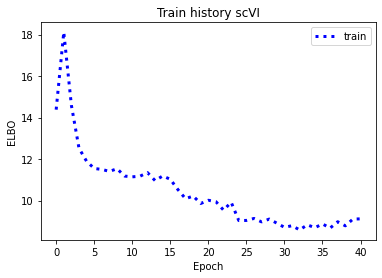

In [153]:
trainer_scvi = UnsupervisedTrainer(model=vae_scvi,
                              gene_dataset=gene_dataset,
                              train_size=1.0,
                              use_cuda=use_cuda,
                              frequency=10,
                              n_epochs_kl_warmup=None)

# train scVI
trainer_scvi.train(n_epochs=n_epochs, lr=1e-3) 
                                        
elbo_train_scvi = trainer_scvi.history["elbo_train_set"]
x = np.linspace(0, 100, (len(elbo_train_scvi)))
plt.plot(np.log(elbo_train_scvi), 
         label="train", color='blue',
         linestyle=':',
         linewidth=3
        )
plt.xlabel('Epoch')
plt.ylabel("ELBO")
plt.legend()
plt.title("Train history scVI")
plt.show()

***scVI Baseline 1 (Average of reconstructions)***

In [154]:
scvi_posterior = trainer_scvi.create_posterior(model=vae_scvi,
                                              gene_dataset=gene_dataset
                                              )

imputed_scvi, imputed_scvi_z = scvi_baseline(tree=tree, 
                                             posterior=scvi_posterior, 
                                             weighted=True,
                                            give_latent=True,
                                            n_samples_z=1)

scvi_latent = scvi_posterior.get_latent()[0]
scvi_latent.shape

(402, 10)

***scVI Baseline 2 (Decoded Average Latent space)***

In [95]:
library_size = np.mean(np.sum(glm.X, axis=1))
imputed_scvi_2, imputed_scvi_2_z = scvi_baseline_z(tree=tree,
                                 model=vae_scvi,
                                 posterior=scvi_posterior,
                                 weighted=True,
                                 n_samples_z=1,
                                 library_size=library_size
                                )


***CascVI Baseline 3***

In [96]:
imputed_cascvi_3 = cascvi_baseline_z(tree=tree,
                                   model=vae_scvi,
                                   latent=imputed_z,
                                   library_size=library_size
                                  )

***(Bonus) MP Imputation with scVI latent space***

In [97]:
empirical_l = library_size

# CascVI impitations
imputed_bis = {}
imputed_z_bis = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed_bis[n.name], imputed_z_bis[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l,
                                                            other_posterior=scvi_posterior
                                                           )

# 5. Likelihood Ratio

In [102]:
cascvi_latent = full_posterior.get_latent()[0]
scvi_latent = scvi_posterior.get_latent()[0]

scvi_latent.shape, cascvi_latent.shape

((402, 10), (402, 10))

In [103]:
vae.initialize_visit()
vae.initialize_messages(scvi_posterior.get_latent()[0], cas_dataset.barcodes, scvi_latent.shape[1])
vae.perform_message_passing((vae.tree & vae.root), scvi_latent.shape[1], False)
mp_lik_scvi = vae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print("Likelihood of scVI encodings: ", mp_lik_scvi.item())

Likelihood of scVI encodings:  -8317.138303959133


In [104]:
vae.initialize_visit()
vae.initialize_messages(full_posterior.get_latent()[0], cas_dataset.barcodes, cascvi_latent.shape[1])
vae.perform_message_passing((vae.tree & vae.root), cascvi_latent.shape[1], False)
mp_lik_cascvi = vae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print("Likelihood of cascVI encodings: ", mp_lik_cascvi.item())

Likelihood of cascVI encodings:  -4223.060739672244


In [105]:
# Likelihood ratio
lambda_ = (mp_lik_cascvi - mp_lik_scvi)
print("Likelihood Ratio:", lambda_)

Likelihood Ratio: tensor(4094.0776, dtype=torch.float64)


# 6. Latent Space Analysis

***Message Passing on "ground truth" latent space***

In [107]:
from utils.baselines import construct_latent
#empirical_l = library_size

# CascVI impitations
#imputed_real = {}
#imputed_z_real = {}

#for n in tree.traverse('levelorder'):
#    if not n.is_leaf():
#        imputed_real[n.name], imputed_z_real[n.name] = full_posterior.imputation_internal(n.name,
#                                                            give_mean=False,
#                                                            library_size=empirical_l,
#                                                            known_latent=leaves_z
#                                                           )
#full_real_latent = construct_latent(tree, leaves_z, imputed_z_real)

#print("Real latent space")
#plot_common_ancestor(tree,
#                     full_real_latent,
#                     embedding='umap',
#                     give_labels=False
#                             )

In [108]:
mu_real = np.clip(a=np.exp(full_real_latent @ glm.W + glm.beta),
                         a_min=0,
                         a_max=5000
                  )

X_real = np.asarray(np.random.poisson(mu_real), dtype=np.float64)
internal_X_real, _, _ = get_internal(X_real, mu_real, tree)
internal_X_real.shape

NameError: name 'full_real_latent' is not defined

***CascVI***

CascVI latent space


/Users/khalilouardini/Desktop/projects/scVI/scvi/utils/plots_util.py:406: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


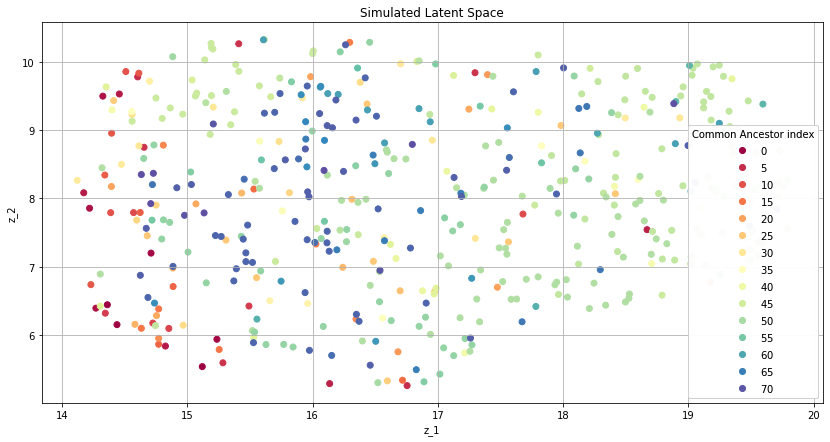

In [109]:
# Merge internal nodes and leaves
full_cascvi_latent = construct_latent(tree, cascvi_latent, imputed_z)


print("CascVI latent space")
plot_common_ancestor(tree,
                     full_cascvi_latent,
                     embedding='umap',
                     give_labels=False
                             )



CascVI + averaging latent space


/Users/khalilouardini/Desktop/projects/scVI/scvi/utils/plots_util.py:406: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


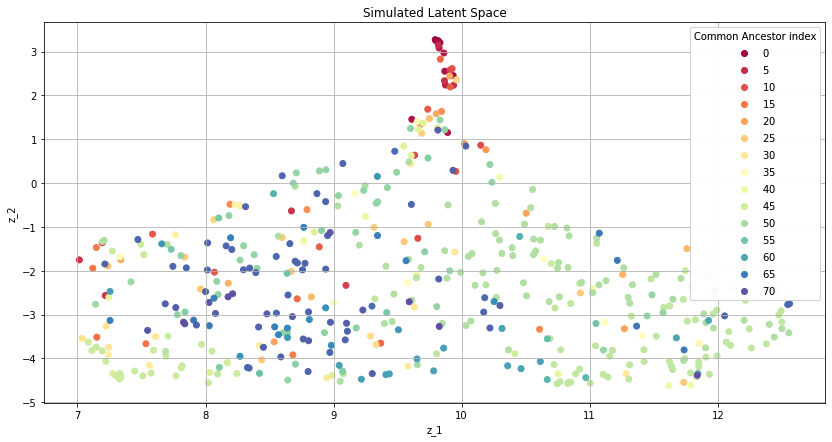

In [110]:
full_cascvi_latent_2 = construct_latent(tree, cascvi_latent, imputed_cascvi_2_z)

print("CascVI + averaging latent space")
plot_common_ancestor(tree,
                     full_cascvi_latent_2,
                     embedding='umap',
                     give_labels=False
                             )

***scVI***

scVI latent space


/Users/khalilouardini/Desktop/projects/scVI/scvi/utils/plots_util.py:406: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


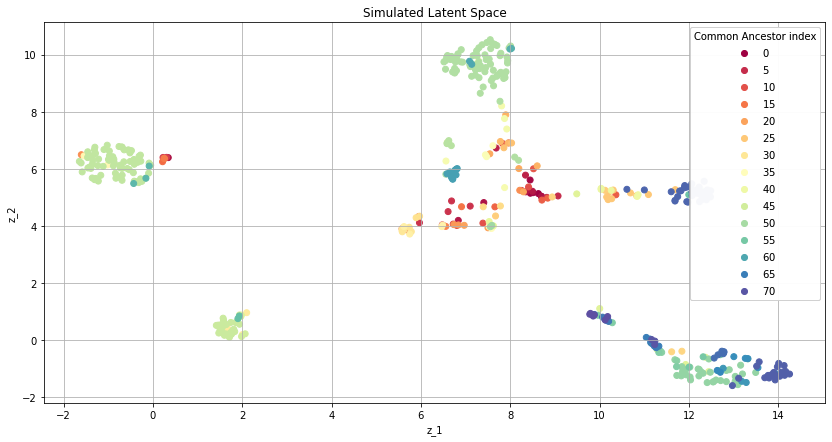

In [111]:
# Merge internal nodes and leaves
full_scvi_latent = construct_latent(tree, scvi_latent, imputed_scvi_2_z)

print("scVI latent space")
plot_common_ancestor(tree,
                 full_scvi_latent,
                 embedding='umap',
                 give_labels=False
                    )

***scVI + Message Passing***

In [ ]:
# Merge internal nodes and leaves
full_scvi_latent_2 = construct_latent(tree, scvi_latent, imputed_z_bis)

print("scVI latent space + Message passing")
plot_common_ancestor(tree,
                 full_scvi_latent_2,
                 embedding='umap',
                 give_labels=False
                    )

***k-NN purity***

Leaves only

In [ ]:
print("Leaves Only")
scores = knn_purity(max_neighbors=50,
              data=[leaves_z, scvi_latent, cascvi_latent],
              plot=True)

Internal nodes only

In [ ]:
print("Internal nodes Only")
internal_z, internal_idx, internal_mu = get_internal(glm.z, glm.mu, tree)
internal_scvi_z, _, _ = get_internal(full_scvi_latent, glm.mu, tree)
internal_scvi_z_2, _, _ = get_internal(full_scvi_latent_2, glm.mu, tree)
internal_cascvi_z, _, _ = get_internal(full_cascvi_latent, glm.mu, tree)
internal_cascvi_z_2, _, _ = get_internal(full_cascvi_latent_2, glm.mu, tree)

scores = knn_purity(max_neighbors=50,
              data=[internal_z, internal_scvi_z, internal_scvi_z_2, internal_cascvi_z, internal_cascvi_z_2],
              plot=True
              )

Full tree

In [ ]:
print("Full tree")
scores = knn_purity(max_neighbors=50,
              data=[glm.z, full_scvi_latent, full_scvi_latent_2, full_cascvi_latent, full_cascvi_latent_2],
              plot=True)

***Stratified k-NN purity***

In [ ]:
for k in [2, 5, 10, 20, 35, 50]:
    print("For {} neighbors".format(k))
    if k == 10:
        min_depth = 3
    elif k == 20:
        min_depth = 4
    elif k == 35:
        min_depth = 6
    elif k == 50:
        min_depth = 7
    else:
        min_depth = 2
    scores = knn_purity_stratified(n_neighbors=k,
                                   tree=tree,
                                   data=[glm.z, full_scvi_latent, full_scvi_latent_2, full_cascvi_latent, full_cascvi_latent_2],
                                   min_depth=min_depth,
                                   plot=True)

# 7. Variance analysis

***Empirical Variance of observed***

In [ ]:
# Get empirical variance of the encoder
qz_v_norm = full_posterior.empirical_qz_v(
                                    n_samples=1000,
                                    norm=True)

In [ ]:
var_dict = {}
node_sizes = []

for i, n in enumerate(tree.traverse('levelorder')):
    if not n.is_leaf():
        # if n is an internal node, we get the variance from the prior
        z = full_posterior.get_latent(give_mean=False)[0]
        _, v_nu = vae.posterior_predictive_density(query_node=n.name, 
                                                  evidence=z) 
        
        var_dict[n.name] = str(np.around(a=v_nu,
                             decimals=4)
                              )
        node_sizes.append(np.around(a=v_nu,
                             decimals=4)
                         )
    else:
        idx = leaves_idx.index(n.index)
        # if n is a leaf, we get the variance from the encoder
        
        # variational distribution variance
        
        # Empirical variance
        var_dict[n.name] = str(np.around(a=qz_v_norm[idx],
                                 decimals=4)
                             )
        node_sizes.append(np.around(a=qz_v_norm[idx],
                                 decimals=4) 
                         )

In [ ]:
var_dict

***Plot variance***

In [ ]:
plot_one_gene(tree=tree, 
              X=imputed_X, 
              g=0, 
              node_sizes=[int(n*10000) for n in node_sizes], #+[1000]
              var='latent',
              size=1000,
              show_index=True,
              save_fig=True,
              figsize=(180, 100)
             )

print("CascVI: Imputations + Variance analysis")

# 7. Evaluation

***CPM Normalization (for sample-sample correlation)***

get imputations into an array

In [ ]:
internal_scvi_X = np.array([x for x in imputed_scvi.values()]).reshape(-1, glm.X.shape[1])
internal_scvi_X_2 = np.array([x for x in imputed_scvi_2.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X = np.array([x for x in imputed_cascvi_1.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X_2 = np.array([x for x in imputed_cascvi_2.values()]).reshape(-1, glm.X.shape[1])
#internal_cascvi_X_3 = np.array([x for x in imputed_cascvi_3.values()]).reshape(-1, glm.X.shape[1])
#internal_cascvi_X_3 = np.array([x for x in imputed_real.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X_3 = internal_X_real

internal_scvi_X.shape, internal_scvi_X_2.shape, internal_cascvi_X.shape, internal_cascvi_X_2.shape, internal_cascvi_X_3.shape

In [ ]:
from sklearn.preprocessing import normalize

norm_internal_X = sc.pp.normalize_total(AnnData(internal_X), target_sum=1e4, inplace=False)['X'] 
norm_scvi_X = sc.pp.normalize_total(AnnData(internal_scvi_X), target_sum=1e4, inplace=False)['X']
norm_scvi_X_2 = sc.pp.normalize_total(AnnData(internal_scvi_X_2), target_sum=1e4, inplace=False)['X']
norm_avg_X = sc.pp.normalize_total(AnnData(internal_avg_X), target_sum=1e4, inplace=False)['X']
norm_imputed_X = sc.pp.normalize_total(AnnData(imputed_X), target_sum=1e4, inplace=False)['X']
norm_cascvi_X = sc.pp.normalize_total(AnnData(internal_cascvi_X), target_sum=1e4, inplace=False)['X']
norm_cascvi_X_2 = sc.pp.normalize_total(AnnData(internal_cascvi_X_2), target_sum=1e4, inplace=False)['X']
norm_cascvi_X_3 = sc.pp.normalize_total(AnnData(internal_cascvi_X_3), target_sum=1e4, inplace=False)['X']

norm_internal_X.shape

## I. Sample-Sample Correlations

***1. Sample-Sample correlation (Without Normalization)***

We will use Scipy to compute a nonparametric rank correlation between the imputed and the groundtruth profiles. The correlation is based on the Spearman Correlation Coefficient.

In [ ]:
data = [internal_X.T, imputed_X.T, internal_avg_X.T ,internal_scvi_X.T,
        internal_scvi_X_2.T, internal_cascvi_X.T, internal_cascvi_X_2.T, internal_cascvi_X_3.T]
df1 = correlations(data, 'None', True)
df1.head(5)
plt.show()

***2. Sample-Sample correlation (With ScanPy Normalization)***

In [ ]:
data = [norm_internal_X.T, norm_imputed_X.T, norm_avg_X.T ,norm_scvi_X.T,
        norm_scvi_X_2.T, norm_cascvi_X.T, norm_cascvi_X_2.T, norm_cascvi_X_3.T]
df2 = correlations(data, 'None', True)
df2.head(5)
plt.show()


## II. Gene-Gene Correlations

***1. Gene-Gene correlation (without Normalization)***

In [ ]:
data = [internal_X, imputed_X, internal_avg_X ,internal_scvi_X,
        internal_scvi_X_2, internal_cascvi_X, internal_cascvi_X_2, norm_cascvi_X_3]
df3 = correlations(data, 'None', True)
df3.head(5)
plt.show()

***2. Gene-Gene correlation (With Normalization)***

In [ ]:
data = [norm_internal_X, norm_imputed_X, norm_avg_X ,
        norm_scvi_X, norm_scvi_X_2, norm_cascvi_X, internal_cascvi_X_2,
       internal_cascvi_X_3]

df4 = correlations(data, 'None', True)
df4.head(5)
plt.show()

***3. Gene-Gene correlation (With Rank Normalization)***

In [ ]:
data = [internal_X, imputed_X, internal_avg_X ,
        internal_scvi_X, internal_scvi_X_2, internal_cascvi_X, internal_cascvi_X_2,
       internal_cascvi_X_3
       ]

df5 = correlations(data, 'rank', True)
df5.head(5)
plt.show()

***4. Gene-Gene correlation (With ScanPy + Rank Normalization)***

In [ ]:
data = [norm_internal_X, norm_imputed_X, norm_avg_X ,
        norm_scvi_X, norm_scvi_X_2, norm_cascvi_X, norm_cascvi_X_2, norm_cascvi_X_3]
df = correlations(data, 'rank', True)
df.head(5)
plt.show()

### III. Table Summary

In [ ]:
columns = ["Method", "Spearman CC", "Pearson CC", "Kendall Tau"]
data = [df1, df2, df3, df4, df5]

tables = [[] for i in range(len(data))]

#task = ["Sample-Sample (None)", "Sample-Sample (CPM)", "Gene-Gene (None)", 
           #"Gene-Gene(CPM)", "Gene-Gene (Rank)" ]

for (df, t) in zip(data, tables):
    for m in np.unique(df.Method):
        sub_df = np.round(df[df['Method'] == m].mean(), decimals=3)
        t.append([m, sub_df['Spearman CC'], sub_df['Pearson CC'], sub_df['Pearson CC']])
        
# Create and style Data Frames
df_table1 = pd.DataFrame(tables[0], columns=columns)
df_table2 = pd.DataFrame(tables[1], columns=columns)
df_table3 = pd.DataFrame(tables[2], columns=columns)
df_table4 = pd.DataFrame(tables[3], columns=columns)
df_table5 = pd.DataFrame(tables[4], columns=columns)

In [ ]:
print(" >>> Sample-Sample | No Normalization <<<")
df_table1.head(10)

In [ ]:
print(">>> Sample-Sample | CPM Normalization <<<")
df_table2.head(10)

In [ ]:
print(">>> Gene-Gene | No Normalization <<<")
df_table3.head(10)

In [ ]:
print(">>> Gene-Gene | CPM Normalization <<<")
df_table4.head(10)

In [ ]:
print(">>> Gene-Gene | Rank Normalization <<<")
df_table5.head(10)

# 8. Exploratory grapghical analysis

***Box plot (Samples)***

In [ ]:
import random
import seaborn as sns

n_samples = 10
idx = random.sample(range(1, 300), n_samples)
n_rows = 2
n_cols = int(n_samples / 2)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 12))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # stack arrrays
        data_boxplot = np.vstack([np.log(1 + norm_internal_X[k]), np.log(1 + norm_imputed_X[k]),
          np.log(1 + norm_avg_X[k]), np.log(1 + norm_scvi_X[k]),
           np.log(1 + norm_cascvi_X[k])]).T
        
        # data frame
        df_boxplot = pd.DataFrame(data=data_boxplot,
                          columns=['Ground truth', 'CascVI', 'Avg', 'Avg scVI', 'Avg CascVI'])
        
        sns.boxplot(ax=ax[i][j], data=df_boxplot, orient="v", palette="Set2", showfliers=True)
        ax[i][j].set_title('Sample ' + str(k))

fig.suptitle("Boxplots of gene expression values")
plt.show()

***Box plot (Genes)***

In [ ]:
import random
import seaborn as sns

n_samples = 10
idx = random.sample(range(1, 1000), n_samples)
n_rows = 2
n_cols = int(n_samples / 2)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 12))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # stack arrrays
        data_boxplot = np.vstack([np.log(1 + norm_internal_X[:, k]), np.log(1 + norm_imputed_X[:, k]),
          np.log(1 + norm_avg_X[:, k]), np.log(1 + norm_scvi_X[:, k]),
           np.log(1 + norm_cascvi_X[:, k])]).T
        
        # data frame
        df_boxplot = pd.DataFrame(data=data_boxplot,
                          columns=['Ground truth', 'CascVI', 'Avg', 'Avg scVI', 'Avg CascVI'])
        
        sns.boxplot(ax=ax[i][j], data=df_boxplot, orient="v", palette="Set2", showfliers=True)
        ax[i][j].set_title('Gene ' + str(k))

fig.suptitle("Boxplots of gene expression values")
plt.show()

***Density plots***

In [ ]:
import random
import seaborn as sns

n_samples = 12
idx = random.sample(range(1, 1000), n_samples)
n_rows = 3
n_cols = int(n_samples / n_rows)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(35, 15))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # density plots
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_imputed_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='cascVI')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_internal_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='groundtruth')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_scvi_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='Avg scVI')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_avg_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='Avg')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_cascvi_X[:, k]), hist=False,
             kde=True, kde_kws={'shade': True}, label='Avg cascVI')
        # set title
        ax[i][j].set_title('Gene ' + str(k))

fig.suptitle("Combined gene density plots")
plt.show()